In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '2'
os.environ["OMP_NUM_THREADS"] = '1'
from vmap_utils import Transformer_fPEPS_Model_batchedAttn, Transformer_fPEPS_Model, random_initial_config, fPEPS_Model, compute_grads, sample_next, evaluate_energy
import pickle
import quimb.tensor as qtn
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
import symmray as sr
import time
import torch

# System parameters
Lx = 8
Ly = 8
nsites = Lx * Ly
D = 4
seed = 42
flat = True

# # random fPEPS
# peps = sr.networks.PEPS_fermionic_rand(
#     "Z2",
#     Lx,
#     Ly,
#     D,
#     phys_dim=[
#         (0, 0),  # linear index 0 -> charge 0, offset 0
#         (1, 1),  # linear index 1 -> charge 1, offset 1
#         (1, 0),  # linear index 2 -> charge 1, offset 0
#         (0, 1),  # linear index 3 -> charge 0, offset 1
#     ],  # -> (0, 3), (2, 1)
#     # put an odd number of odd sites in, for testing
#     # site_charge=lambda site: int(site in [(0, 0), (0, 1), (1, 0)]),
#     subsizes="equal",
#     flat=flat,
#     seed=seed,
# )
# Load PEPS
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/vmc_torch/experiment/vmap/data'
u1z2 = True
appendix = '_U1SU' if u1z2 else ''
t = 1.0
U = 8.0
N_f = nsites - 8
# Hamiltonian
H = spinful_Fermi_Hubbard_square_lattice_torch(
    Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=(N_f//2, N_f//2), no_u1_symmetry=False,
)
params_path = f'{pwd}/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/Z2/D={D}/'
params = pickle.load(open(params_path + f'peps_su_params{appendix}.pkl', 'rb'))
skeleton = pickle.load(open(params_path + f'peps_skeleton{appendix}.pkl', 'rb'))
peps = qtn.unpack(params, skeleton)
for ts in peps.tensors: 
    ts.modify(data=ts.data.to_flat()*10)
for site in peps.sites: 
    peps[site].data._label = site
    peps[site].data.indices[-1]._linearmap = ((0, 0), (1, 0), (1, 1), (0, 1)) # Important for U1->Z2 fPEPS

In [4]:
# Prepare initial samples
# batchsize per rank
B_list = [1, 8, 16, 20, 24, 28, 32, 36, 40, 44, 48,  64, 80,  96, ]
time_list = []
grad_time_list = []
# asume we need 20000 samples in total
# calculate how much cores we need for each batch size, assuming doing only 1 step of MC sampling
num_cores_list = [20000 // B for B in B_list]
for B in B_list:
    fxs = []
    for _ in range(B):
        fxs.append(random_initial_config(nsites, nsites))
    fxs = torch.stack(fxs, dim=0)
    model = Transformer_fPEPS_Model_batchedAttn(
        tn=peps,
        max_bond=D+2,
        nn_eta=1,
        nn_hidden_dim=peps.nsites,
        embed_dim=16,
        attn_heads=4,
        dtype=torch.float64,
    )
    # model = fPEPS_Model(
    #     tn=peps,
    #     max_bond=D,
    #     dtype=torch.float64,
    # )
    model(fxs[:10])  # warm up
    nparams = sum(p.numel() for p in model.parameters())
    t0 = time.time()
    model(fxs)
    t1 = time.time()
    compute_grads(fxs, model, vectorize=True, batch_size=B, vmap_grad=True)
    t2 = time.time()
    time_list.append((t1-t0))
    grad_time_list.append((t2-t1))

 -> Clamping output layer (Conv2d) weights to scale 1e-05


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/nn/functional.py:6487: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  attn_output = scaled_dot_product_attention(
/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05
 -> Clamping output layer (Conv2d) weights to scale 1e-05


In [ ]:
from vmc_torch.experiment.vmap.vmap_utils import sample_next, evaluate_energy, compute_grads
B = 40
fxs = []
for _ in range(B):
    fxs.append(random_initial_config(nsites, nsites))
fxs = torch.stack(fxs, dim=0)
model = Transformer_fPEPS_Model_batchedAttn(
        tn=peps,
        max_bond=D,
        nn_eta=1,
        nn_hidden_dim=peps.nsites,
        embed_dim=16,
        attn_heads=4,
        dtype=torch.float64,
    )
t0 = time.time()
fxs, current_amps = sample_next(fxs, model, H.graph, verbose=True)
energy_batch, local_energies_batch =evaluate_energy(fxs, model, H, current_amps=current_amps, verbose=True)
grads_vec_batch, amps_batch = compute_grads(fxs, model, vectorize=True, batch_size=B, vmap_grad=True)
t1 = time.time()
print('Time (B=%d): %.4f s'%(B, t1 - t0))

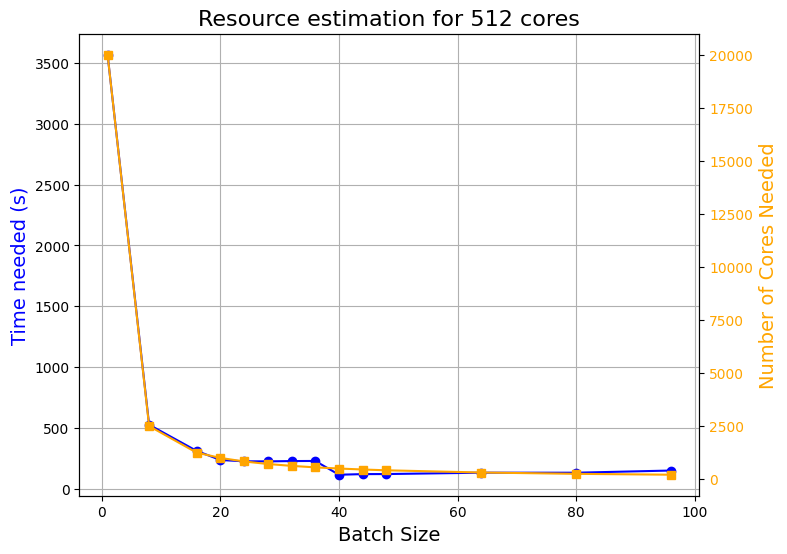

In [9]:
# assuming we have 1000 cores fixed, calculate time needed to get 20000 samples for each batch size
# and plot
# note that each core needs to at least run 1 MC step, so there is a minimum time per batch size - increasing batch size does not unlimitedly reduce time
fixed_cores = 512
samples_per_core = 20000 // fixed_cores
adjusted_time_list = []
mc_steps_needed_list = []
for i, B in enumerate(B_list):
    mc_steps_needed = (samples_per_core + B - 1) // B  # ceiling division
    mc_steps_needed_list.append(mc_steps_needed)
    adjusted_time = time_list[i] * mc_steps_needed * 4 * nsites + grad_time_list[i] * mc_steps_needed
    adjusted_time_list.append(adjusted_time)
actual_samples_per_core = [B*((20000 // fixed_cores + B - 1) // B) for B in B_list]
actual_total_samples = [(20000 // B + 1) * B for B in B_list]

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(B_list, adjusted_time_list, marker='o', color='blue')
ax.set_xlabel('Batch Size', fontsize=14)
ax.set_ylabel('Time needed (s)', fontsize=14, color='blue')
ax.set_title(f'Resource estimation for {fixed_cores} cores', fontsize=16)
ax.grid(True)
# plot number of cores on right y axis
ax2 = ax.twinx()
ax2.plot(B_list, num_cores_list, color='orange', marker='s')
ax2.set_ylabel('Number of Cores Needed', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

# plt.xticks(B_list)
plt.savefig(f'./data/fPEPS_Transformer_batchsize_vs_time_{Lx}x{Ly}_D={D}_chi={model.chi}.png', dpi=300)

In [10]:
# Define column widths
w1, w2, w3, w4, w5 = 6, 25, 18, 20, 15

# Print Header
header = (
    f"{'B':^{w1}} || "
    f"{'actual_samples/core':^{w2}} || "
    f"{'mc_steps':^{w3}} || "
    f"{'adj_time':^{w4}} || "
    f"{'total_samples':^{w5}}"
)
print(header)
print("-" * len(header))

# Print Data
for i in range(len(B_list)):
    print(
        f"{B_list[i]:>{w1}.2f} || "               # Fixed float width for B
        f"{actual_samples_per_core[i]:>{w2}} || " # Integer alignment
        f"{mc_steps_needed_list[i]:>{w3}} || "     # Integer alignment
        f"{adjusted_time_list[i]:>{w4}.4f} || "   # 4 decimal places
        f"{actual_total_samples[i]:>{w5}}"
    )

# Save the form as a text file
with open(f'./data/fPEPS_Transformer_batchsize_vs_time_{Lx}x{Ly}_D={D}_chi={model.chi}.txt', 'w') as file:
    print(f'{Lx}x{Ly} t={t} U={U} N={N_f} D={D} chi={model.chi} Transformer_fPEPS_Model_batchedAttn\n', file=file)
    # Write Header
    file.write(header + '\n')
    file.write("-" * len(header) + '\n')

    # Write Data
    for i in range(len(B_list)):
        file.write(
            f"{B_list[i]:>{w1}.2f} || "               # Fixed float width for B
            f"{actual_samples_per_core[i]:>{w2}} || " # Integer alignment
            f"{mc_steps_needed_list[i]:>{w3}} || "     # Integer alignment
            f"{adjusted_time_list[i]:>{w4}.4f} || "   # 4 decimal places
            f"{actual_total_samples[i]:>{w5}}\n"
        )

  B    ||    actual_samples/core    ||      mc_steps      ||       adj_time       ||  total_samples 
----------------------------------------------------------------------------------------------------
  1.00 ||                        39 ||                 39 ||            3565.7844 ||           20001
  8.00 ||                        40 ||                  5 ||             527.6181 ||           20008
 16.00 ||                        48 ||                  3 ||             313.2922 ||           20016
 20.00 ||                        40 ||                  2 ||             238.4934 ||           20020
 24.00 ||                        48 ||                  2 ||             227.3575 ||           20016
 28.00 ||                        56 ||                  2 ||             226.9024 ||           20020
 32.00 ||                        64 ||                  2 ||             229.4451 ||           20032
 36.00 ||                        72 ||                  2 ||             230.3523 ||       

In [11]:
from vmc_torch.experiment.vmap.vmap_utils import sample_next, evaluate_energy, compute_grads
B = 40
fxs = []
for _ in range(B):
    fxs.append(random_initial_config(nsites, nsites))
fxs = torch.stack(fxs, dim=0)
model = Transformer_fPEPS_Model_batchedAttn(
        tn=peps,
        max_bond=D,
        nn_eta=1,
        nn_hidden_dim=peps.nsites,
        embed_dim=16,
        attn_heads=4,
        dtype=torch.float64,
    )
t0 = time.time()
fxs, current_amps = sample_next(fxs, model, H.graph, verbose=True)
energy_batch, local_energies_batch =evaluate_energy(fxs, model, H, current_amps=current_amps, verbose=True)
grads_vec_batch, amps_batch = compute_grads(fxs, model, vectorize=True, batch_size=B, vmap_grad=True)
t1 = time.time()
print('Time (B=%d): %.4f s'%(B, t1 - t0))

 -> Clamping output layer (Conv2d) weights to scale 1e-05


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/nn/functional.py:6487: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  attn_output = scaled_dot_product_attention(


Time (B=40): 84.5855 s


/home/sijingdu/TNVMC/VMC_code/clean_symmray/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_for_cpu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [49]:
from vmc_torch.experiment.vmap.vmap_utils import flatten_params
from torch.utils._pytree import tree_map, tree_flatten

def compute_grads_decoupled(fxs, fpeps_model, batch_size=None):
    """
    解耦合梯度计算 (支持 Chunking 以节省内存)：
    Step 1: 前向计算 NN, 拿到数值上的 delta_P (backflow correction)
    Step 2: 计算 TN 的梯度 (分批 vmap, 拿到 sensitivity vector)
    Step 3: 将 sensitivity vector 回传给 NN (VJP, 逐样本循环)
    """
    B = fxs.shape[0]
    dtype = fpeps_model.dtype
    
    # 确定 chunk size，如果未指定则一次性算完
    B_grad = batch_size if batch_size is not None else B
    
    # === 准备参数 ===
    ftn_params = list(fpeps_model.ftn_params)
    nn_params = list(fpeps_model.nn_backflow.parameters())
    nn_params_dict = dict(zip(fpeps_model.nn_param_names, nn_params))

    # =================================================================
    # Step 1: NN Forward (Native Batch)
    # 目的：获取 delta_P 的数值，作为 TN 的输入。
    # =================================================================
    # 这一步通常内存占用不大（相比 TN），所以我们可以一次性算完。
    # 如果显存非常吃紧，也可以把这一步放入下面的循环中，但逻辑会稍微复杂一点。
    with torch.no_grad():
        batch_delta_p = torch.func.functional_call(
            fpeps_model.nn_backflow, nn_params_dict, fxs.to(dtype)
        )
    # batch_delta_p shape: (B, ftn_params_length)

    # =================================================================
    # Step 2: TN Backward (Chunked vmap over grad)
    # 目的：计算 psi 对 delta_P 的敏感度 (Sensitivity)
    # =================================================================
    
    # 定义纯 TN 收缩函数
    def tn_only_func(x_i, ftn_p_list, delta_p_i):
        amp = fpeps_model.tn_contraction(x_i, ftn_p_list, delta_p_i)
        return amp, amp # (Target, Aux)

    # 定义 vmap 函数
    tn_grad_vmap_func = torch.vmap(
        torch.func.grad(tn_only_func, argnums=(1, 2), has_aux=True), 
        in_dims=(0, None, 0)
    )

    # --- 开始 Chunking 循环 ---
    g_ftn_chunks = []
    g_sensitivity_chunks = []
    amps_chunks = []

    for b_start in range(0, B, B_grad):
        b_end = min(b_start + B_grad, B)
        
        # 1. 切片 (Slicing)
        fxs_chunk = fxs[b_start:b_end]
        delta_p_chunk = batch_delta_p[b_start:b_end]
        
        # 2. 计算当前 chunk 的梯度
        # (g_ftn_chunk, g_sensitivity_chunk), amps_chunk
        (g_ftn_c, g_sens_c), amps_c = tn_grad_vmap_func(fxs_chunk, ftn_params, delta_p_chunk)
        
        # 3. 立即 Detach Amps 以释放 TN 计算图 (关键!)
        if amps_c.requires_grad:
            amps_c = amps_c.detach()
            
        # 4. 存储结果
        g_ftn_chunks.append(g_ftn_c)        # 这是一个 list/tuple of tensors
        g_sensitivity_chunks.append(g_sens_c)
        amps_chunks.append(amps_c)
        
        # 显式删除临时变量，辅助 GC
        del g_ftn_c, g_sens_c, amps_c

    # --- 拼接结果 (Aggregation) ---
    
    # 1. 拼接 g_sensitivity (B, Out)
    g_sensitivity = torch.cat(g_sensitivity_chunks, dim=0)
    
    # 2. 拼接 amps (B, 1)
    amps = torch.cat(amps_chunks, dim=0)
    if amps.dim() == 1:
        amps = amps.unsqueeze(-1)

    # 3. 拼接 g_ftn (PyTree 结构)
    # g_ftn_chunks 是一个列表，里面每一个元素都是一个 tuple(tensor_param_1, tensor_param_2, ...)
    # 我们需要把它们按照 parameter 的位置，沿着 dim=0 拼起来
    # 使用 tree_map 可以优雅地处理这个结构
    g_ftn = tree_map(lambda *leaves: torch.cat(leaves, dim=0), *g_ftn_chunks)

    # 此时，TN 部分的大内存已经释放完毕

    # =================================================================
    # Step 3: NN Backward (Sequential Loop)
    # 目的：利用 g_sensitivity 计算 NN 参数的梯度
    # =================================================================
    # 这一步本身就是逐样本的，天然节省内存，直接复用你之前的逻辑即可
    
    g_nn_params_list = []
    
    for i in range(B):
        x_i = fxs[i].unsqueeze(0) 
        g_sens_i = g_sensitivity[i].unsqueeze(0) 
        
        fpeps_model.nn_backflow.zero_grad()
        
        with torch.enable_grad():
            out_i = torch.func.functional_call(
                fpeps_model.nn_backflow, 
                nn_params_dict, 
                x_i.to(dtype)
            )
            target = torch.sum(out_i * g_sens_i.detach())
            grads_i = torch.autograd.grad(target, nn_params, retain_graph=False)
            
        flat_g = flatten_params(grads_i)
        g_nn_params_list.append(flat_g)
        
    g_nn_params_vec = torch.stack(g_nn_params_list)

    # =================================================================
    # Step 4: 拼装最终结果
    # =================================================================
    
    # Flatten g_ftn
    leaves, _ = tree_flatten(g_ftn)
    flat_g_ftn_list = [leaf.flatten(start_dim=1) for leaf in leaves]
    g_ftn_params_vec = torch.cat(flat_g_ftn_list, dim=1)

    g_params_vec = torch.cat([g_ftn_params_vec, g_nn_params_vec], dim=1) # (B, Np_total)
    
    return g_params_vec, amps

g_params_vec, amps = compute_grads_decoupled(fxs, model, batch_size=6)
g_params_vec_benchmark, amps_benchmark = compute_grads(fxs, model, vectorize=True)
g_params_vec.shape, g_params_vec_benchmark.shape
torch.allclose(g_params_vec, g_params_vec_benchmark)

True

In [8]:
import quimb as qu
tn = peps.copy()
params, skeleton = qtn.pack(tn)
# for torch, further flatten pytree into a single list
ftn_params_flat, ftn_params_pytree = qu.utils.tree_flatten(
    params, get_ref=True
)
ftn_params = torch.nn.ParameterList([
    torch.as_tensor(x, dtype=torch.float64) for x in ftn_params_flat
])
ftn_params

ParameterList(
    (0): Parameter containing: [torch.float64 of size 4x2x2x2]
    (1): Parameter containing: [torch.float64 of size 4x2x2x2]
    (2): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (3): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (4): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (5): Parameter containing: [torch.float64 of size 8x2x2x2x2]
    (6): Parameter containing: [torch.float64 of size 4x2x2x2]
    (7): Parameter containing: [torch.float64 of size 4x2x2x2]
)